In [1]:
import sys
from os.path import join
from os import makedirs
import numpy as np
from tqdm import tqdm
from numpy.random import choice
import importlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PROJ_DIR = '/home/gcgreen2/alignment'
GIT_DIR = join(PROJ_DIR, 'SequenceAlignmentAndSketching')

In [3]:
sys.path.append(GIT_DIR)
from utils import seq_utils as su

In [4]:
importlib.reload(su)

<module 'utils.seq_utils' from '/home/gcgreen2/alignment/SequenceAlignmentAndSketching/utils/seq_utils.py'>

In [5]:
DSET_DIR = join(GIT_DIR, 'data')
FASTA_DIR = join(PROJ_DIR, 'spectral_jaccard_similarity/filtered_fasta')
DATASETS = np.loadtxt(join(PROJ_DIR,'NCTC_list.txt'), dtype=str)
BASES = ['A','T','C','G']

## Get read length distribution

In [10]:
fasta_file = join(FASTA_DIR, DATASETS[0]+'_reads.fasta')
seqs = su.get_seqs(fasta_file)
n_reads = len(seqs)

In [11]:
base_count = {b:0 for b in su.BASES}
for seq in seqs:
    for b in seq:
        base_count[b]+=1

In [12]:
print(list(base_count.keys()))
counts = list(base_count.values())
print([c/sum(counts) for c in counts])

['T', 'A', 'C', 'G']
[0.30445290034981376, 0.30485254050215727, 0.20079290290233398, 0.18990165624569497]


(array([  4.,  26., 177., 307., 252., 132.,  78.,  21.,   4.,   2.]),
 array([  902. ,  3793.2,  6684.4,  9575.6, 12466.8, 15358. , 18249.2,
        21140.4, 24031.6, 26922.8, 29814. ]),
 <BarContainer object of 10 artists>)

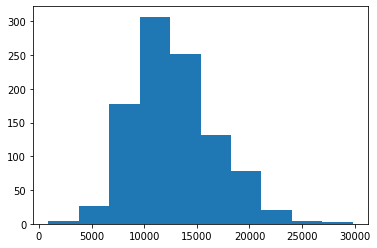

In [13]:
READ_LENS = [len(s) for s in seqs]
np.random.shuffle(READ_LENS)
plt.hist(READ_LENS)

## Make simulated datasets

In [14]:
def find_overlaps(read_locs, read_lens, thresh=100):
    overlaps = pd.DataFrame(columns=['i1','i2','overlap','l1','l2'])

    for i1 in range(n_reads):
        loc1,len1 = read_locs[i1],read_lens[i1]
        end1 = loc1 + len1

        for i2 in range(i1-1,-1,-1):
            loc2,len2 = read_locs[i2],read_lens[i2]
            end2 = loc2+len2
            overlap = min(end2-loc1, len1)
            if overlap > thresh:
                overlaps.loc[len(overlaps)] = [i1+1,i2+1,overlap,len1,len2]
            else: break

        for i2 in range(i1+1,n_reads):
            loc2,len2 = read_locs[i2],read_lens[i2]
            overlap = min(end1-loc2, len2)
            if overlap > thresh:
                overlaps.loc[len(overlaps)] = [i1+1,i2+1,overlap,len1,len2]
            else: break
    return overlaps

In [15]:
def create_dset(out_dir, genome, reads, read_lens, read_locs, overlaps, noiseless_reads=None, n_errors=None):
    makedirs(out_dir, exist_ok=True)
    fasta_path = join(out_dir,'reads.fasta')
    noiseless_fasta_path = join(out_dir,'reads_orig.fasta')
    genome_path = join(out_dir,'genome.fasta')
    n_errors_path = join(out_dir, 'n_errors.tsv')
    gt_path = join(out_dir, 'ground_truth.txt')
    read_locs_path = join(out_dir, 'read_locs.txt')
    read_lens_path = join(out_dir, 'read_lens.txt')

    np.savetxt(read_lens_path, read_lens)
    np.savetxt(read_locs_path, read_locs)
    su.write_fasta(fasta_path, reads)
    if noiseless_reads is not None: su.write_fasta(noiseless_fasta_path, noiseless_reads)
    if n_errors is not None: np.savetxt(n_errors_path, n_errors, fmt='%d', delimiter='\t', header='n_sub\tn_ins\tn_del')
    su.write_fasta(genome_path, ('genome',genome))
    overlaps.to_csv(gt_path, sep='\t', header=False, index=False)

In [16]:
def extract_reads(genome, read_lens, size=1982012):
    read_locs = np.sort(choice(np.arange(size-max(read_lens)), size=n_reads))
    reads = [''.join(genome[loc:loc+l]) for loc,l in zip(read_locs,read_lens)]
    reads = [(str(i+1),r) for i,r in enumerate(reads)]
    return reads, read_locs

def iid_reads(read_lens, size=1982012, p=4*[0.25]):
    size = 1982012 # size of NCTC1080 
    genome = choice(BASES, size=size, p=p)
    read_locs = np.sort(choice(np.arange(size-max(read_lens)), size=n_reads))
    reads = [''.join(genome[loc:loc+l]) for loc,l in zip(read_locs,read_lens)]
    reads = [(str(i+1),r) for i,r in enumerate(reads)]
    return reads, read_locs, genome

## iid genome & reads

In [18]:
out_dir = join(DSET_DIR, 'unif')
reads, read_locs, genome = iid_reads(READ_LENS)
overlaps = find_overlaps(read_locs, READ_LENS)
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps)

#### Make overlaps DF

In [19]:
len(overlaps)

11656

(array([1765., 1994., 2131., 2527., 1841.,  957.,  327.,   92.,   14.,
           8.]),
 array([103.0, 2374.3, 4645.6, 6916.900000000001, 9188.2, 11459.5,
        13730.800000000001, 16002.100000000002, 18273.4, 20544.7, 22816.0],
       dtype=object),
 <BarContainer object of 10 artists>)

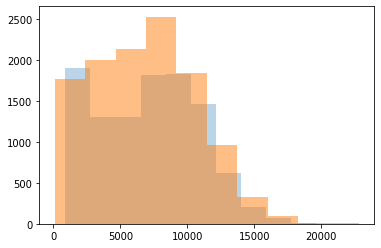

In [20]:
# histogram of overlaps for NCTC ground truth vs Unif
nctc_gt = '/home/gcgreen2/alignment/spectral_jaccard_similarity/groundTruths/NCTC1080_daligner_ground_truth.txt'
plt.hist(np.loadtxt(nctc_gt, usecols=[2], dtype=float),alpha=0.3)
plt.hist(overlaps['overlap'].values,alpha=0.5)

## iid non-uniform genome (base freq equal to NCTC reads)

In [21]:
out_dir = join(DSET_DIR, 'gc0.2')
reads, read_locs, genome = iid_reads(READ_LENS, p=[0.3,0.3,0.2,0.2])
overlaps = find_overlaps(read_locs, READ_LENS)
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps)

## Extract manual reads from NCTC 1080 genome

In [22]:
out_dir = join(DSET_DIR, 'nctc1080')
genome_path = join(out_dir, 'ERS846866.fasta')
genome = su.get_seqs(genome_path)[0]

In [23]:
len(genome)

1982012

In [25]:
reads, read_locs = extract_reads(genome, READ_LENS)
overlaps = find_overlaps(read_locs, READ_LENS)
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps)

# Noisy reads

In [26]:
def add_noise(noiseless_reads, sub=0, insert=0, delete=0):
    correct = 1-sub-delete
    reads = []
    n_errors = []
    for read_id,read in tqdm(noiseless_reads):
        noisy_read = ''
        n_sub, n_ins, n_del = 0,0,0
        for b in read:
            event = choice([0,1,2], p=[correct,sub,delete])
            if event==0: #correct
                b2 = b
            elif event==1: #substitution
                n_sub += 1
                p = 4*[1/3] # unif substitution prob
                p[BASES.index(b)] = 0 # chance of same base = 0
                b2 = choice(BASES, p=p)
            elif event==2:
                n_del += 1
                b2 = ''
            noisy_read += b2
            if event != 2:
                while(np.random.binomial(1,p=insert)): #add insertions after each base (including inserted bases) 
                    n_ins += 1
                    noisy_read += choice(BASES)  
        reads.append((read_id, noisy_read))
        n_errors.append([n_sub, n_ins, n_del])
    return reads, n_errors

### error rates from "Benchmarking of long-read correction methods"

In [27]:
# sub_prob_dict = {'A':[0,7/21,8/21,6/21],
#                 'T':[7/21,0,6/21,8/21],
#                 'C':[12/28,8/28,0,8/28],
#                 'G':[8/29,12/29,9/29,0]}
sub_prob = 0.0168
ins_prob = 0.0804
del_prob = 0.0316
med_sub = 0.25
high_sub = 0.5


## substitutions

In [28]:
# GC=0.2
out_dir = join(DSET_DIR, 'gc0.2_sub1.68')
noiseless_reads, read_locs, genome = iid_reads(READ_LENS, p=[0.3,0.3,0.2,0.2])
reads, n_errors = add_noise(noiseless_reads, sub=sub_prob)
overlaps = find_overlaps(read_locs, READ_LENS) 
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps, noiseless_reads, n_errors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [07:10<00:00,  2.33it/s]


## insertions 

In [29]:
# GC=0.2
out_dir = join(DSET_DIR, 'gc0.2_ins8.04')
noiseless_reads, read_locs, genome = iid_reads(READ_LENS, p=[0.3,0.3,0.2,0.2])
reads, n_errors = add_noise(noiseless_reads, insert=ins_prob)
overlaps = find_overlaps(read_locs, READ_LENS) 
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps, noiseless_reads, n_errors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [07:20<00:00,  2.27it/s]


## deletions 

In [30]:
# GC=0.2
out_dir = join(DSET_DIR, 'gc0.2_del3.16')
noiseless_reads, read_locs, genome = iid_reads(READ_LENS, p=[0.3,0.3,0.2,0.2])
reads, n_errors = add_noise(noiseless_reads, delete=del_prob)
overlaps = find_overlaps(read_locs, READ_LENS) 
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps, noiseless_reads, n_errors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [06:50<00:00,  2.44it/s]


## indels 

In [31]:
# GC=0.2
out_dir = join(DSET_DIR, 'gc0.2_ins8.04_del3.16')
noiseless_reads, read_locs, genome = iid_reads(READ_LENS, p=[0.3,0.3,0.2,0.2])
reads, n_errors = add_noise(noiseless_reads, insert=ins_prob, delete=del_prob)
overlaps = find_overlaps(read_locs, READ_LENS) 
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps, noiseless_reads, n_errors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [07:20<00:00,  2.28it/s]


## all 

In [32]:
# GC=0.2
out_dir = join(DSET_DIR, 'gc0.2_sub1.68_ins8.04_del3.16')
noiseless_reads, read_locs, genome = iid_reads(READ_LENS, p=[0.3,0.3,0.2,0.2])
reads, n_errors = add_noise(noiseless_reads, sub=sub_prob, insert=ins_prob, delete=del_prob)
overlaps = find_overlaps(read_locs, READ_LENS) 
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps, noiseless_reads, n_errors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [07:29<00:00,  2.23it/s]


## med sub 

In [34]:
# GC=0.2
out_dir = join(DSET_DIR, 'gc0.2_sub25')
noiseless_reads, read_locs, genome = iid_reads(READ_LENS, p=[0.3,0.3,0.2,0.2])
reads, n_errors = add_noise(noiseless_reads, sub=med_sub, insert=ins_prob, delete=del_prob)
overlaps = find_overlaps(read_locs, READ_LENS) 
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps, noiseless_reads, n_errors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [09:07<00:00,  1.83it/s]


## high sub 

In [33]:
# GC=0.2
out_dir = join(DSET_DIR, 'gc0.2_sub50')
noiseless_reads, read_locs, genome = iid_reads(READ_LENS, p=[0.3,0.3,0.2,0.2])
reads, n_errors = add_noise(noiseless_reads, sub=med_sub, insert=ins_prob, delete=del_prob)
overlaps = find_overlaps(read_locs, READ_LENS) 
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps, noiseless_reads, n_errors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [10:16<00:00,  1.63it/s]


# Malaria 

In [18]:
out_dir = join(DSET_DIR, 'malaria')
chr_paths = [join(out_dir, 'GCA_900632045.1', f'chr{i+1}.fna') for i in range(16)]
reads, read_locs, genome = iid_reads(READ_LENS)
overlaps = find_overlaps(read_locs, READ_LENS)
create_dset(out_dir, genome, reads, READ_LENS, read_locs, overlaps)